In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#db.create_pgpass_file()


c:\Users\Yass La Menace\anaconda3\envs\Coding\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\2012917318.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df=pd.read_csv('data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918


# **Part 3: Betting Against Beta**

## Estimating rolling betas

In [3]:
#Copying df3frame for safe measure
df3=df.copy()


In [4]:
#Drop NaNs
df3=df3.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

#Remove scarce df3 
df3['N'] = df3.groupby(['permno'])['date'].transform('count')
df3 = df3[df3['N']>60].copy()

#Estimate Rolling Betas
cov_nm = df3.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

#reconstruct df
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
df3 = pd.merge(df3, beta_n, on=['date','permno'], how='left')

#Winsorsize
df3['beta'] = df3['beta'].clip(df3['beta'].quantile(0.05),df3['beta'].quantile(0.95))

#Show first 5 rows
df3.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,beta
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,91,NaN
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,91,NaN
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,91,NaN
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,91,NaN
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,91,NaN


## PF Decile

In [5]:
#Generate Quantiles
df3=df3.dropna(subset=['beta']).copy()
df3['beta_q']=df3.groupby('date')['beta'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df3.groupby(['date','beta_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_q')['Rn'].mean()*12
ew_ret_std = ret_ew.groupby('beta_q')['Rn'].std()*(np.sqrt(12))
ew_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)



# Value-weighed pfs
df3['vw_Q']=df3['mcap']/(df3.groupby(['date','beta_q'])['mcap'].transform('sum'))
df3['ret_vw'] = df3['vw_Q']*df3['Rn']
ret_vw = df3.groupby(['date','beta_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_q')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('beta_q')['ret_vw'].std()*(np.sqrt(12))
vw_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

In [6]:
#Constuct df7frames for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

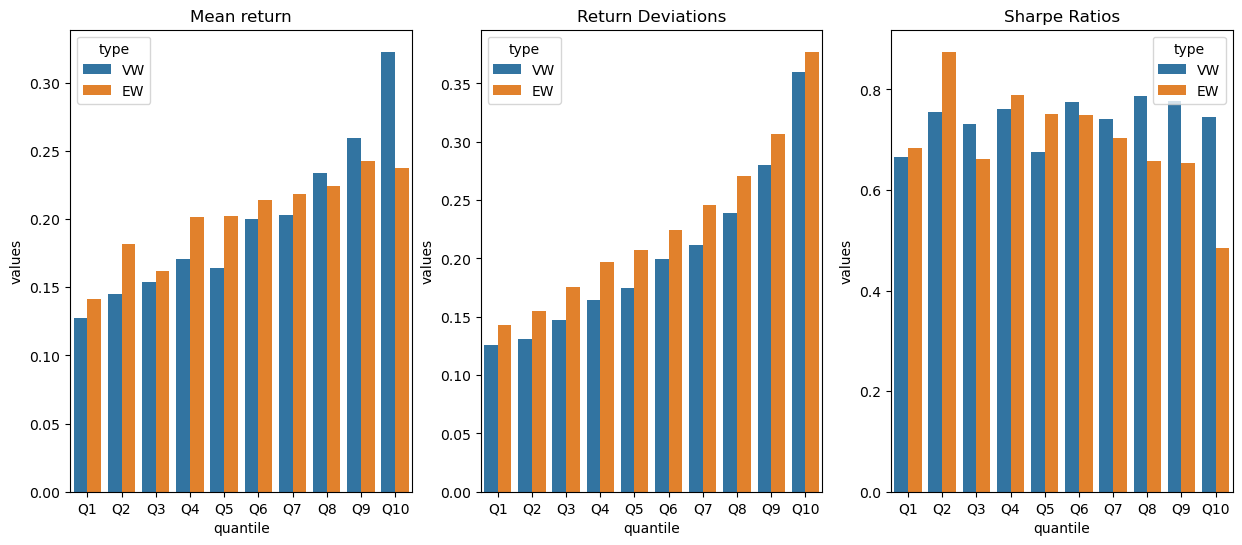

In [7]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()


## BAB PF Construction

In [8]:
# Weights
df3['z'] = df3.groupby('date')['beta'].transform(lambda x: x.rank())
df3['z_'] = df3['z']-df3.groupby('date')['z'].transform('mean')
df3['k'] = np.abs(df3['z_'])
df3['k'] = 2/df3.groupby('date')['k'].transform('sum')
df3['w_H'] = df3['k'] * df3['z_'] * (df3['z_']>0) 
df3['w_L'] = -df3['k'] * df3['z_'] * (df3['z_']<0)

# Weighted returns and beta
df3['beta_H'] = df3['w_H'] * df3['beta']
df3['beta_L'] = df3['w_L'] * df3['beta']
df3['R_H'] = df3['w_H'] * df3['Rn']
df3['R_L'] = df3['w_L'] * df3['Rn']
df3['R_H_e'] = df3['w_H'] * df3['Rn_e']
df3['R_L_e'] = df3['w_L'] * df3['Rn_e']
BAB = df3.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']


In [9]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,df3[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.06595251340689118 2.643255295965815
Sharpe Ratio of BAB factor:  0.7529084322616696
Idiosyncatic volatility:  0.11172317210612583
Beta BAB:  0.5009795423577799
Market Risk Premium:  0.07872392238908113
Market Volatility:  0.16833715761798662


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\3891231813.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Alpha_bab = OLS_Reg.params[0]*12
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\3891231813.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_bab = OLS_Reg.params[1]
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\3891231813.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print

# **Part 5: Idiosyncratic Volatility**


In [10]:
df5=df.copy()
df5.dropna(subset=['Rn_e','Rm_e'],inplace=True)


In [11]:
volatilities = {}
window=60
min_periods=36
for permno, group in df5.groupby('permno'):
    rolling = group.set_index('date')[['Rn_e', 'Rm_e']].rolling(window, min_periods=min_periods)
    curr_dict = {}
    for window in rolling:
        X = sm.add_constant(window[['Rm_e']])
        y = window['Rn_e']
        results = sm.OLS(y, X).fit()
        preds = results.predict(X)
        idio_vol = (y - preds).std()*np.sqrt(12)
        date = window.iloc[-1].name
        curr_dict[date] = idio_vol 
    volatilities[permno] = curr_dict

# transform the dictionary into a DataFrame
idio_df = pd.DataFrame(volatilities).T.stack().reset_index().rename(columns={'level_0':'permno', 'level_1':'date', 0:'idio_vol'})
# export the DataFrame to a csv file
idio_df.to_csv('idio_vol.csv', index=False)

ValueError: window must be an integer 0 or greater

In [12]:
df_idio=pd.read_csv('idio_vol.csv')
df_idio['date']=pd.to_datetime(df_idio['date'])
df_idio.head()

,permno,date,idio_vol
0,10001,2010-05-28,8.073456e-17
1,10001,2010-04-30,1.602407e-01
2,10001,2010-03-31,2.125114e-01
3,10001,2010-02-26,1.990379e-01
4,10001,2010-01-29,1.815296e-01


In [13]:
df5=df5.merge(df_idio,on=['date','permno'])
df5['idio_vol'] = df5['idio_vol'].clip(df5['idio_vol'].quantile(0.05), df5['idio_vol'].quantile(0.95))
df5.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,0.234753
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241


## Decile soting

In [14]:
#Generate Quantiles
df5=df5.dropna(subset=['idio_vol']).copy()
df5['idio_q']=df5.groupby('date')['idio_vol'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df5.groupby(['date','idio_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('idio_q')['Rn'].mean()*12
ew_rf_mean=df5.groupby('idio_q')['rf'].mean()*12
ew_ret_std = ret_ew.groupby('idio_q')['Rn'].std()*(np.sqrt(12))
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)


# Value-weighed pfs
df5['vw_Q']=df5['mcap']/(df5.groupby(['date','idio_q'])['mcap'].transform('sum'))
df5['ret_vw'] = df5['vw_Q']*df5['Rn']

ret_vw = df5.groupby(['date','idio_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('idio_q')['ret_vw'].mean()*12
vw_rf_mean = df5.groupby('idio_q')['rf'].mean()*12
vw_ret_std = ret_vw.groupby('idio_q')['ret_vw'].std()*(np.sqrt(12))
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

df5.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,0.234753,3,0.000058,9.418648e-06
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,1,0.000022,-4.225192e-07
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,2,0.000030,-1.993227e-08
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511,2,0.000034,7.063250e-07
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241,1,0.000034,4.252436e-06


In [15]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])


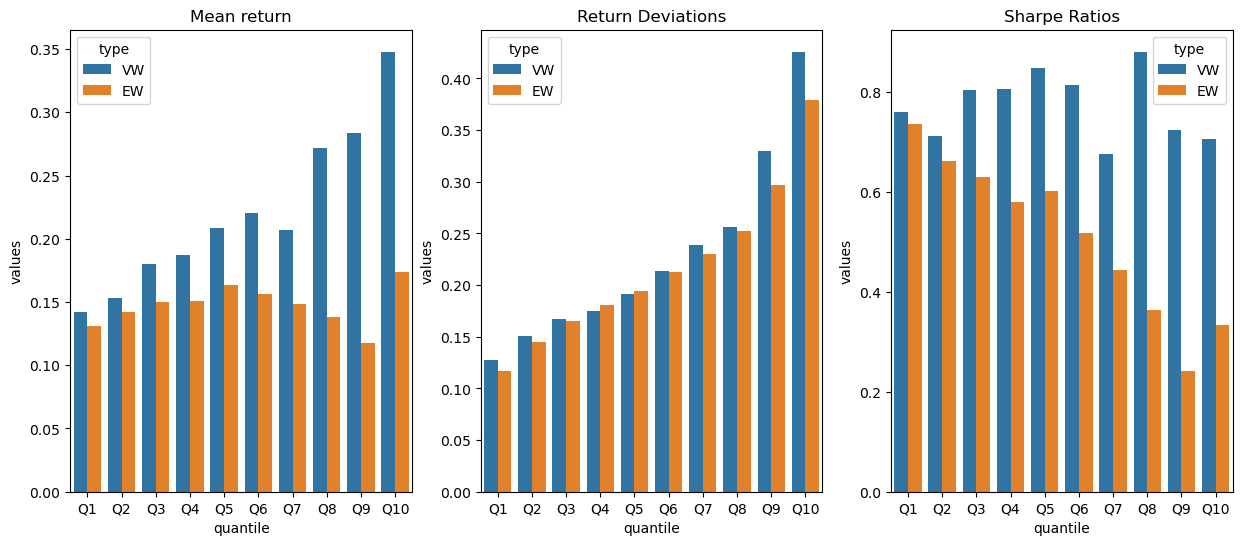

In [16]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()



## Constructing Volatility portfolio

In [17]:
##Construct three dataframes, one for the strategy and one for the higher deciels and lower decile portfolios
df_deciles=df5[df5['idio_q'].isin([0,1,2,7,8,9])].copy()
df_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]
df_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]

Equal weighted strategy

In [18]:
## Short the 3 lowest decile returns to apply the strategy
df_deciles['Rn']=df_deciles.apply(lambda row: (-1)*row['Rn'] if row['idio_q'] in [0,1, 2] else row['Rn'], axis=1)

In [19]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_h['Rn'].mean()*12
mean_l=df_l['Rn'].mean()*12
mean_strat=df_deciles['Rn'].mean()*12

std_h=df_h['Rn'].std()*(np.sqrt(12))
std_l=df_l['Rn'].std()*(np.sqrt(12))
std_strat=df_deciles['Rn'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat-df_deciles['rf'].mean())/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.1311663026506812, Low Deciles: 0.1394767771257518, Strategy: -0.007679182874185329
-----Annual Return Deviations-----
High Deciles: 0.7587824156208495, Low Deciles: 0.2782079293938284, Strategy: 0.5671075065973974
-----Sharpe Ratios-----
High Deciles: 0.1677681272355872, Low Deciles: 0.4876418261180054, Strategy: -0.020308903907202712


In [20]:
## Statistical testing for pvalues
from scipy.stats import ttest_ind
_, pval=ttest_ind(df_deciles.groupby('date')['Rn'].mean()*12,0)
print(pval)

0.9822501277241381


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are not statistically different that 0.

In [21]:

df_deciles['ret_vw']=df_deciles.apply(lambda row: (-1)*row['ret_vw'] if row['idio_q'] in [0,1, 2] else row['ret_vw'], axis=1)
df_deciles['is_long']=df_deciles.apply(lambda row:  0 if row['idio_q'] in [0,1, 2] else 1, axis=1)
df_deciles.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw,is_long
1,10001,2010-01-29,0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,1,0.000022,4.225192e-07,0
2,10001,2010-02-26,0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,2,0.000030,1.993227e-08,0
3,10001,2010-03-31,-0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511,2,0.000034,-7.063250e-07,0
4,10001,2010-04-30,-0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241,1,0.000034,-4.252436e-06,0
5,10001,2010-05-28,-0.004829,6071.0,11.4000,4925,69209.4000,66028.8000,0.000114,-0.079240,1,0.004715,-0.079354,0.149543,0,0.000022,-1.083125e-07,0


In [22]:
df_deciles['vw_Q2']=df_deciles['mcap']/(df_deciles.groupby(['date','is_long'])['mcap'].transform('sum'))
df_deciles['ret_vw2'] = df_deciles['vw_Q2']*df_deciles['Rn']

In [23]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]['ret_vw2'].mean()*12
mean_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]['ret_vw2'].mean()*12
mean_strat=df_deciles['ret_vw'].mean()*12

std_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]['ret_vw2'].std()*(np.sqrt(12))
std_l==df_deciles[df_deciles['idio_q'].isin([0,1,2])]['ret_vw2'].std()*(np.sqrt(12))
std_strat=df_deciles['ret_vw2'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat-df_deciles['rf'].mean())/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.0005003035391538687, Low Deciles: -0.00025117861098489464, Strategy: 0.00032218183449051645
-----Annual Return Deviations-----
High Deciles: 0.0035840503476969633, Low Deciles: 0.2782079293938284, Strategy: 0.0026049201916501967
-----Sharpe Ratios-----
High Deciles: -0.939298820309729, Low Deciles: -0.014601068400429391, Strategy: -1.3497408324193951


In [24]:
## Statistical testing for pvalues
_, pval=ttest_ind(df_deciles.groupby('date')['ret_vw2'].mean()*12,0)
print(pval)

0.8595397103661633


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are not statistically different that 0.

# **PART 4: Momentum Protfolio**

In [25]:
df=pd.read_csv('data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918


**MOMENTUM**

In [26]:
#Cumulative 12 month past return for each stock:
df=df.sort_values(['permno','date']).reset_index(drop=True)
df['LN_Cret12'] = df.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).values
df['Rn_f'] = df.groupby(['permno'])['Rn'].shift(-1)
df.head()

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\2346461583.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['LN_Cret12'] = df.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).values


,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Rn_f
0,10001,2009-12-31,0.162621,4361.0,10.3000,4925,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,NaN,-0.018932
1,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,NaN,-0.000656
2,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,NaN,0.020643
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,NaN,0.124385
4,10001,2010-04-30,0.124385,6070.0,11.3900,4925,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,NaN,0.004829


In [27]:
df4=df.copy()
#Momentum decile weights
q = 10
#Momentum is the decile
df4['Momentum'] = df4.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
df4['w_L'] = (df4['Momentum']==q-1)*df4['mcap']
df4['w_S'] = (df4['Momentum']==0)*df4['mcap']
#Normalize the weights
df4['w_L'] = df4['w_L']/df4.groupby(['date'])['w_L'].transform('sum')
df4['w_S'] = df4['w_S']/df4.groupby(['date'])['w_S'].transform('sum')
df4['w_Mom'] = df4['w_L'] - df4['w_S']
Momentum = df4.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()
Momentum['date'] =  Momentum['date'] + pd.DateOffset(months=1)
Momentum.columns = ['date','Mom_ret']

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\1375466105.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Momentum = df4.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()


In [28]:
#Generate deciles
df_momentum=df4.dropna(subset=['Momentum']).copy()
df_momentum['momentum_deciles']=df_momentum.groupby('date')['Momentum'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df_momentum.groupby(['date','momentum_deciles'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('momentum_deciles')['Rn'].mean()*12
ew_ret_std = ret_ew.groupby('momentum_deciles')['Rn'].std()*(np.sqrt(12))
ew_rf_mean=df_momentum.groupby('momentum_deciles')['rf'].mean()*12
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)



# Value-weighed pfs
df_momentum['vw_Q']=df_momentum['mcap']/(df_momentum.groupby(['date','momentum_deciles'])['mcap'].transform('sum'))
df_momentum['ret_vw'] = df_momentum['vw_Q']*df_momentum['Rn']
ret_vw = df_momentum.groupby(['date','momentum_deciles'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('momentum_deciles')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('momentum_deciles')['ret_vw'].std()*(np.sqrt(12))
vw_rf_mean=df_momentum.groupby('momentum_deciles')['rf'].mean()*12
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

In [29]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

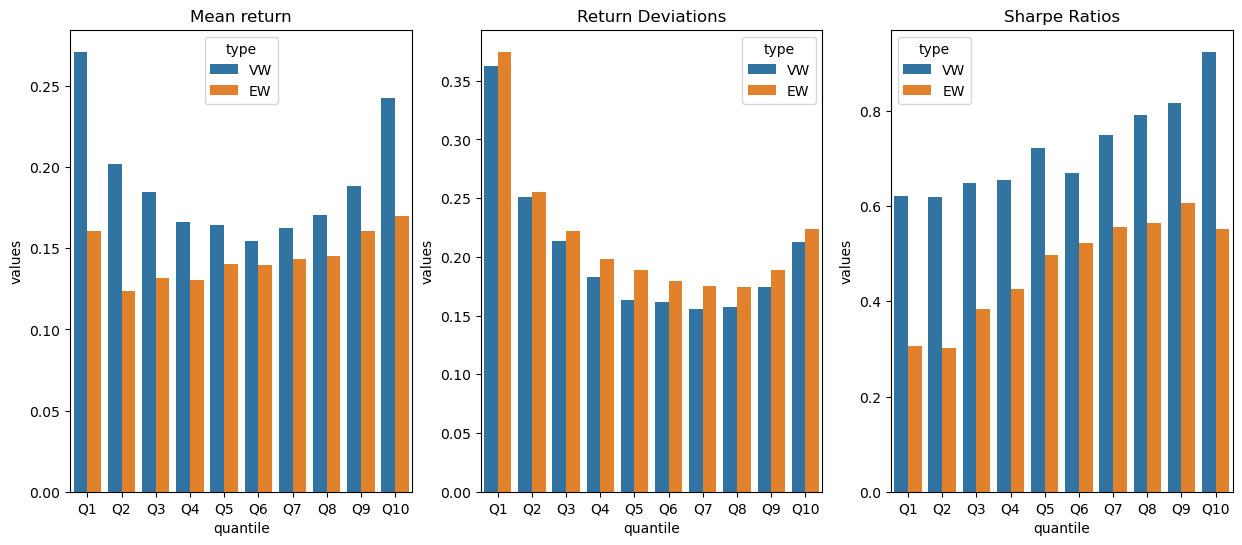

In [30]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()

# **PART 6: Optimal Fund Portfolio Return**

In [31]:
target_volatility=0.1

In [32]:
BAB.head(2)

,date,R_H,R_L,R_H_e,R_L_e,beta_H,beta_L,BAB2
0,1967-02-28,0.047351,0.030975,0.043614,0.027238,2.037561,0.706332,0.017158
1,1967-06-30,0.129090,0.038484,0.126001,0.035395,1.974961,0.647834,-0.009163


In [33]:
df_momentum.head(2)


,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,...,Rm_e,LN_Cret12,Rn_f,Momentum,w_L,w_S,w_Mom,momentum_deciles,vw_Q,ret_vw
11,10001,2010-11-30,-0.118436,7834.0,10.04,4925,78653.36,82413.68,0.000142,0.005117,...,0.004975,0.297149,0.052291,7.0,0.0,0.0,0.0,7,0.000098,-0.000012
12,10001,2010-12-31,0.052291,7834.0,10.52,4925,82413.68,84450.52,0.000068,0.067182,...,0.067114,0.020414,0.028992,3.0,0.0,0.0,0.0,3,0.000042,0.000002


In [34]:
df_deciles.head(2)

,permno,date,Rn,shrout,prc,siccd,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw,is_long,vw_Q2,ret_vw2
1,10001,2010-01-29,0.018932,4361.0,10.0600,4925,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,1,0.000022,4.225192e-07,0,0.000007,1.259253e-07
2,10001,2010-02-26,0.000656,4361.0,10.0084,4925,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,2,0.000030,1.993227e-08,0,0.000007,4.271925e-09


In [35]:
r_bab=BAB.copy()
r_mom=df_momentum.groupby('date')['ret_vw'].sum().copy()
r_iv=df_deciles.groupby('date')['ret_vw2'].sum().copy()

In [36]:
r_strat=r_bab.merge(r_mom,on='date').merge(r_iv,on='date')
r_strat.rename(columns={'BAB2':'ret_bab',	'ret_vw':'ret_mom',	'ret_vw2':'ret_iv'},inplace=True)
r_strat=r_strat[['date','ret_bab', 'ret_mom', 'ret_iv']]
r_strat.head()

,date,ret_bab,ret_mom,ret_iv
0,1967-02-28,0.017158,0.124858,0.099530
1,1967-06-30,-0.009163,0.402861,0.172845
2,1967-08-31,0.016275,-0.039215,0.050066
3,1967-11-30,0.004062,0.130700,-0.010785
4,1968-02-29,-0.021274,-0.440869,-0.054229


## Equal weighed returns

In [37]:
r_strat['ret_ew']= r_strat[['ret_bab', 'ret_mom', 'ret_iv']].mean(axis=1)
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew
0,1967-02-28,0.017158,0.124858,0.099530,0.080515
1,1967-06-30,-0.009163,0.402861,0.172845,0.188848
2,1967-08-31,0.016275,-0.039215,0.050066,0.009042
3,1967-11-30,0.004062,0.130700,-0.010785,0.041325
4,1968-02-29,-0.021274,-0.440869,-0.054229,-0.172124


## Risk parity

In [38]:
window_size=60
min_req=36
# Calculate rolling window volatility for each column
r_strat['volatility_bab'] = r_strat['ret_bab'].rolling(window=window_size,min_periods=min_req).std()
r_strat['volatility_mom'] = r_strat['ret_mom'].rolling(window=window_size,min_periods=min_req).std()
r_strat['volatility_iv'] = r_strat['ret_iv'].rolling(window=window_size,min_periods=min_req).std()

r_strat['total_vol']=(1/r_strat['volatility_bab'])+ (1/r_strat['volatility_mom' ])+ (1/r_strat['volatility_iv'])

r_strat['w_bab']=(1/r_strat['volatility_bab'])/r_strat['total_vol']    
r_strat['w_mom']=(1/r_strat['volatility_mom' ])/r_strat['total_vol']    
r_strat['w_iv']=(1/r_strat['volatility_iv'])/r_strat['total_vol']

r_strat['ret_rp']=r_strat['ret_bab']*r_strat['w_bab']+r_strat['ret_iv']*r_strat['w_iv']+r_strat['ret_mom']*r_strat['w_mom']

r_strat=r_strat[['date','ret_bab','ret_mom','ret_iv','ret_ew','ret_rp']]
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,ret_rp
0,1967-02-28,0.017158,0.124858,0.099530,0.080515,NaN
1,1967-06-30,-0.009163,0.402861,0.172845,0.188848,NaN
2,1967-08-31,0.016275,-0.039215,0.050066,0.009042,NaN
3,1967-11-30,0.004062,0.130700,-0.010785,0.041325,NaN
4,1968-02-29,-0.021274,-0.440869,-0.054229,-0.172124,NaN


Setting up risk free rates for the mean variance efficient pf


In [39]:
rf_df=df.groupby('date')['rf'].mean()
r_strat=r_strat.merge(rf_df,on='date',how='left')
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,ret_rp,rf
0,1967-02-28,0.017158,0.124858,0.099530,0.080515,NaN,0.003737
1,1967-06-30,-0.009163,0.402861,0.172845,0.188848,NaN,0.003089
2,1967-08-31,0.016275,-0.039215,0.050066,0.009042,NaN,0.003216
3,1967-11-30,0.004062,0.130700,-0.010785,0.041325,NaN,0.003491
4,1968-02-29,-0.021274,-0.440869,-0.054229,-0.172124,NaN,0.003894


## Mean Variance efficient

In [40]:
## TODO: add rf rates+ look at ps3 for rolling average and stds
def compute_tangency_w(data):
    rf=data['rf'].mean()
    cov=data[['ret_bab','ret_mom','ret_iv']].cov().values*12
    inv_cov=np.linalg.inv(cov)
    mu=np.array([data['ret_bab'].mean()-rf*12,data['ret_mom'].mean()-rf*12,data['ret_iv'].mean()-rf*12])
    w= (inv_cov @ mu)/(np.ones(3)@inv_cov@mu)
    return w

In [41]:
w=compute_tangency_w(r_strat)

In [42]:
r_strat['ret_mve']=w[0]*r_strat['ret_bab']+w[1]*r_strat['ret_mom']+w[2]*r_strat['ret_iv']
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,ret_rp,rf,ret_mve
0,1967-02-28,0.017158,0.124858,0.099530,0.080515,NaN,0.003737,0.039855
1,1967-06-30,-0.009163,0.402861,0.172845,0.188848,NaN,0.003089,0.030423
2,1967-08-31,0.016275,-0.039215,0.050066,0.009042,NaN,0.003216,0.031635
3,1967-11-30,0.004062,0.130700,-0.010785,0.041325,NaN,0.003491,-0.008894
4,1968-02-29,-0.021274,-0.440869,-0.054229,-0.172124,NaN,0.003894,-0.007503


## Calculating constants

In [43]:
c_ew=np.sqrt(target_volatility**2/(r_strat['ret_ew'].std()**2))
c_rp=np.sqrt(target_volatility**2/(r_strat['ret_rp'].std()**2))
c_mve=np.sqrt(target_volatility**2/(r_strat['ret_mve'].std()**2))

print(f'Scaling constants EW:{c_ew}, RP:{c_rp}, MVE: {c_mve}')

Scaling constants EW:0.47471691686270906, RP:1.869820069835859, MVE: 4.106390702825333


In [44]:
#Constuct dataframes for efficient plotting 
strats=['EW','RP','MVE']
means=[r_strat['ret_ew'].mean(),r_strat['ret_rp'].mean(),r_strat['ret_mve'].mean()]
means_df=pd.DataFrame(zip(means,strats,strats),columns=['values','type','quantile'])
stds=[r_strat['ret_ew'].std(),r_strat['ret_rp'].std(),r_strat['ret_mve'].std()]
stds_df=pd.DataFrame(zip(stds,strats,strats),columns=['values','type','quantile'])
srs=(np.array(means)-np.array([r_strat['rf'].mean()]*3))/np.array(stds)
srs_df=pd.DataFrame(zip(srs,strats,strats),columns=['values','type','quantile'])

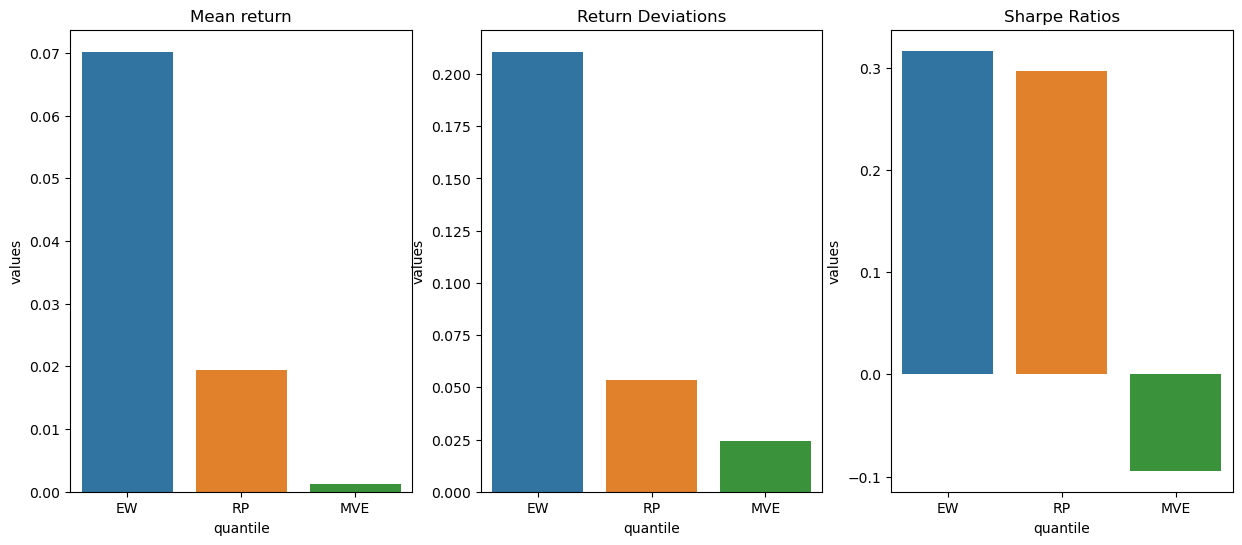

In [45]:
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()

## 7 Performance and risk analysis for the Fund strategy

 Going forward, we pick the approach with the risk-parity

## a)

In [116]:
print(df3.columns.tolist())

['permno', 'date', 'Rn', 'shrout', 'prc', 'siccd', 'mcap', 'mcap_l', 'rf', 'Rm', 'const', 'Rn_e', 'Rm_e', 'N', 'beta', 'beta_q', 'vw_Q', 'ret_vw', 'z', 'z_', 'k', 'w_H', 'w_L', 'beta_H', 'beta_L', 'R_H', 'R_L', 'R_H_e', 'R_L_e']


In [117]:

df7=df3[['permno', 'date', 'Rn', 'shrout','siccd', 'prc', 'mcap', 'mcap_l', 'rf', 'Rm', 'Rn_e', 'Rm_e','const','beta']]
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,Rn_e,Rm_e,const,beta
36,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,0.062650,0.054091,1,0.464682
37,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,0.011611,0.008242,1,0.484416
38,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,0.030650,0.035261,1,0.484182
44,10001,2013-09-30,0.004412,10372.0,4925,10.20,105794.40,103408.84,0.000017,0.037497,0.004395,0.037480,1,0.479719
48,10001,2014-01-31,0.147572,10452.0,4925,9.17,95844.84,97830.72,0.000042,-0.030020,0.147530,-0.030062,1,0.429576


In [118]:
# Define the date range
start_date = '1964-01-01'
end_date = '2023-12-31'


In [119]:
Strat=r_strat[['date','ret_rp']]

In [120]:
Industry_Returns = pd.read_csv('12_Industry_Portfolios.CSV',index_col='date')
Industry_Returns = Industry_Returns[(Industry_Returns.index >= start_date) & (Industry_Returns.index <= end_date)]
Industry_Returns.index = pd.to_datetime(Industry_Returns.index, format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
Industry_Returns.head()



,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,
1964-01-31,0.8,1.22,2.49,4.85,3.1,2.99,3.32,1.4,2.52,3.7,-1.18,2.77
1964-02-29,1.86,1.64,3.11,1.08,1.98,1.91,-0.28,0.87,1.63,1.65,3.85,6.37
1964-03-31,3.08,1.08,4.22,1.4,2.61,3.42,-0.9,-0.74,2.43,-1.94,0.68,3.39
1964-04-30,-0.47,1.8,-1.79,4.04,-1.48,-3.79,0.83,1.05,2.88,-1.42,-1.02,1.1
1964-05-31,1.56,1.52,1.58,2.15,2.09,2.83,-0.39,0.84,3.91,0.52,-0.03,3.85


In [121]:
# Get the list of all the SIC codes
with open('Siccodes12.txt', 'r') as file:
    lines = file.readlines()

dic = {}

for j in range(0, 7000):
    dic[j] = 12
    sic = lines[0].strip().split(" ")[0]
    i = 1
    while i < len(lines)-2:
        if lines[i].strip() == "":
            sic = lines[i+1].strip().split(" ")[0]
            i += 2
            continue
        else:
            a = lines[i].strip().split("-")
            if j in range(int(a[0]), int(a[1])+1):
                dic[j] = sic
            i += 1

df_ind = pd.DataFrame(dic.items(), columns=['SIC', 'FF_12'])

df_ind.to_csv('48_Industries.csv', index=False)

In [122]:
df_ind.head()

,SIC,FF_12
0,0,12
1,1,12
2,2,12
3,3,12
4,4,12


In [123]:
#WE SHOULD DO SMTH LIKE THAT TO START FROM 1964 BUT SHIT AINT WORKING
#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------

Industry_Definitions = pd.read_csv('48_Industries.CSV')
Industry_Definitions.rename(columns={'SIC':'siccd'},inplace=True)
Industries = Industry_Returns.columns.tolist()
#num_industries = len(Industries)
Industry_Names = pd.DataFrame(Industries, index=np.arange(1,13 )).reset_index() #num_industries+1
Industry_Names.columns=['Industry','Name']

In [124]:
Industries

['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth ',
 'Money',
 'Other']

In [125]:
Industry_Returns.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,
1964-01-31,0.8,1.22,2.49,4.85,3.1,2.99,3.32,1.4,2.52,3.7,-1.18,2.77
1964-02-29,1.86,1.64,3.11,1.08,1.98,1.91,-0.28,0.87,1.63,1.65,3.85,6.37
1964-03-31,3.08,1.08,4.22,1.4,2.61,3.42,-0.9,-0.74,2.43,-1.94,0.68,3.39
1964-04-30,-0.47,1.8,-1.79,4.04,-1.48,-3.79,0.83,1.05,2.88,-1.42,-1.02,1.1
1964-05-31,1.56,1.52,1.58,2.15,2.09,2.83,-0.39,0.84,3.91,0.52,-0.03,3.85


In [126]:
df7=pd.merge(df7,Industry_Definitions[['siccd','FF_12']],on=['siccd'], how='left')

In [127]:
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,Rn_e,Rm_e,const,beta,FF_12
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,0.062650,0.054091,1,0.464682,8.0
1,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,0.011611,0.008242,1,0.484416,8.0
2,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,0.030650,0.035261,1,0.484182,8.0
3,10001,2013-09-30,0.004412,10372.0,4925,10.20,105794.40,103408.84,0.000017,0.037497,0.004395,0.037480,1,0.479719,8.0
4,10001,2014-01-31,0.147572,10452.0,4925,9.17,95844.84,97830.72,0.000042,-0.030020,0.147530,-0.030062,1,0.429576,8.0


In [128]:
df7 = pd.merge(df7, Industry_Returns,on=['date'], how='left')

# Convert the relevant columns to numeric, coercing errors
for industry in Industries:
    df7[industry] = pd.to_numeric(df7[industry], errors='coerce')

# Convert rf to a numpy array
rf_array = np.array(df7['rf'])

# Perform the arithmetic operation
df7[Industries] = df7[Industries] / 100 - rf_array[:, np.newaxis]



In [129]:
df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.056349,0.074649,0.067949,0.023549,0.048449,0.050449,0.055749,0.080749,0.062349,0.076449
1,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.070749,0.066149,0.090349,0.064449,0.085249,0.051049,0.061349,0.090949,0.081949,0.067649
2,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.012860,0.006760,0.012660,0.006660,0.022860,0.021960,0.008460,0.013160,0.011760,0.017760
3,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.011060,-0.017340,0.003160,0.012660,-0.014940,0.021960,0.008960,-0.003440,0.025460,0.012560
4,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
FF5=pd.read_csv('F-F_5_Factors.csv')
FF5['date'] = pd.to_datetime(FF5['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
# Filter the data to include only the dates within the specified range
FF5 = FF5[(FF5['date'] >= start_date) & (FF5['date'] <= end_date)]
# Display the first few rows of the filtered data
FF5.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
6,1964-01-31,2.24,0.13,1.48,0.17,1.47,0.30
7,1964-02-29,1.54,0.28,2.81,-0.05,0.91,0.26
8,1964-03-31,1.41,1.23,3.40,-2.21,3.22,0.31
9,1964-04-30,0.10,-1.52,-0.67,-1.27,-1.08,0.29
10,1964-05-31,1.42,-0.63,1.86,-0.16,0.17,0.26


In [131]:
df7 = pd.merge(df7, FF5,on=['date'], how='left')
Fama_French = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
# Convert the relevant columns to numeric, coercing errors
for factor in Fama_French:
    df7[factor] = pd.to_numeric(df7[factor], errors='coerce')

# Perform the arithmetic operation
df7[Fama_French] = df7[Fama_French] / 100 

df7.head()

,permno,date,Rn,shrout,siccd,prc,mcap,mcap_l,rf,Rm,...,Shops,Hlth,Money,Other,Mkt-RF,SMB,HML,RMW,CMA,RF
0,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.055749,0.080749,0.062349,0.076449,0.0557,0.0048,0.0096,-0.0193,0.0141,0.0
1,10001,2013-01-31,0.062701,8157.0,4925,9.87,80509.59,81080.58,0.000051,0.054142,...,0.061349,0.090949,0.081949,0.067649,0.0557,0.0048,0.0096,-0.0193,0.0141,0.0
2,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.008460,0.013160,0.011760,0.017760,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0
3,10001,2013-02-28,0.011651,8157.0,4925,9.94,81080.58,83201.40,0.000040,0.008282,...,0.008960,-0.003440,0.025460,0.012560,0.0129,-0.0025,0.0011,-0.0067,0.0052,0.0
4,10001,2013-03-28,0.030684,8157.0,4925,10.20,83201.40,86668.70,0.000034,0.035295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
# Inspect column names for any issues
print(Industry_Returns.columns)

# Check for leading/trailing whitespaces in column names
Industry_Returns.columns = Industry_Returns.columns.str.strip()

# Re-check column names after stripping whitespace
print(Industry_Returns.columns)

Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth ', 'Money', 'Other'],
      dtype='object')
Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')


In [133]:
print(Strat.head())
print(df7.head())

        date  ret_rp
0 1967-02-28     NaN
1 1967-06-30     NaN
2 1967-08-31     NaN
3 1967-11-30     NaN
4 1968-02-29     NaN
   permno       date        Rn  shrout  siccd    prc      mcap    mcap_l  \
0   10001 2013-01-31  0.062701  8157.0   4925   9.87  80509.59  81080.58   
1   10001 2013-01-31  0.062701  8157.0   4925   9.87  80509.59  81080.58   
2   10001 2013-02-28  0.011651  8157.0   4925   9.94  81080.58  83201.40   
3   10001 2013-02-28  0.011651  8157.0   4925   9.94  81080.58  83201.40   
4   10001 2013-03-28  0.030684  8157.0   4925  10.20  83201.40  86668.70   

         rf        Rm  ...     Shops     Hlth      Money     Other  Mkt-RF  \
0  0.000051  0.054142  ...  0.055749  0.080749  0.062349  0.076449  0.0557   
1  0.000051  0.054142  ...  0.061349  0.090949  0.081949  0.067649  0.0557   
2  0.000040  0.008282  ...  0.008460  0.013160  0.011760  0.017760  0.0129   
3  0.000040  0.008282  ...  0.008960 -0.003440  0.025460  0.012560  0.0129   
4  0.000034  0.035295  ... 

In [134]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'Strat' and 'df7' are already defined and include the necessary data

# Ensure the 'date' columns are in datetime format
Strat['date'] = pd.to_datetime(Strat['date'])
df7['date'] = pd.to_datetime(df7['date'])

# Define the list of industry and Fama-French columns
Industries = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
Fama_French = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Strip any leading or trailing spaces from column names
df7.columns = df7.columns.str.strip()
Strat.columns = Strat.columns.str.strip()


if 'date' not in df7.columns:
    raise KeyError("'date' column not found in df7")
if 'date' not in Strat.columns:
    raise KeyError("'date' column not found in Strat")

# Merge the dataframes on 'date'
tmp = pd.merge(Strat, df7[['date'] + Industries + Fama_French].drop_duplicates(), on='date', how='left')

# Add a constant column for the regression
tmp['const'] = 1

# Drop rows with any NaN values
tmp = tmp.dropna()


# Industry Exposure
RegOLS = sm.OLS(tmp['ret_rp'], tmp[['const'] + Industries + Fama_French]).fit()

# Print regression parameters and R-squared value
print(f"Regression parameters:\n{pd.concat([RegOLS.params, RegOLS.tvalues], axis=1)}\n")
print(f'R^2: {RegOLS.rsquared}')


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\102283111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Strat['date'] = pd.to_datetime(Strat['date'])


Regression parameters:
               0         1
const   0.008617  7.101931
NoDur   0.176149  2.701049
Durbl   0.093884  3.260440
Manuf   0.044462  0.588239
Enrgy  -0.053886 -3.171379
Chems  -0.091564 -1.532533
BusEq  -0.002055 -0.047823
Telcm  -0.034009 -1.011813
Utils   0.182108  4.378900
Shops   0.054835  0.976617
Hlth   -0.043322 -1.351350
Money   0.002286  0.041239
Other   0.155693  2.124763
Mkt-RF  0.531787  6.573613
SMB     0.342027  6.337602
HML     0.156858  2.020882
RMW    -0.130575 -2.020709
CMA     0.000326  0.003911

R^2: 0.8626656318549171


1. significative negative exposure to energy industry
2. durable, non durable,energy, utils  and other are three most significative industry factors
3. mkt excess returns, SMB, HML and RRMW are the most significative factors of fama-french
4. alpha is 0.8% and highly statistacly significative : industry actors explain the strategies expected return
4. R^2 is 86%: industry  and fama_french factors explain more thand three-quarters of the strategy's return

## GPT Analysis

- Market Risk Premium (Mkt-RF) and Size Factor (SMB) are the most critical factors influencing your strategy's returns.

- Among industry factors, Utilities (Utils), Durables (Durbl), and Energy (Enrgy) are the most relevant, with Utilities and Durables having a positive impact and Energy having a negative impact.
- The high R-squared value (
0.8627
0.8627) indicates that the model explains a significant portion of the variance in your strategy's returns, confirming the importance of these factors.

## b)

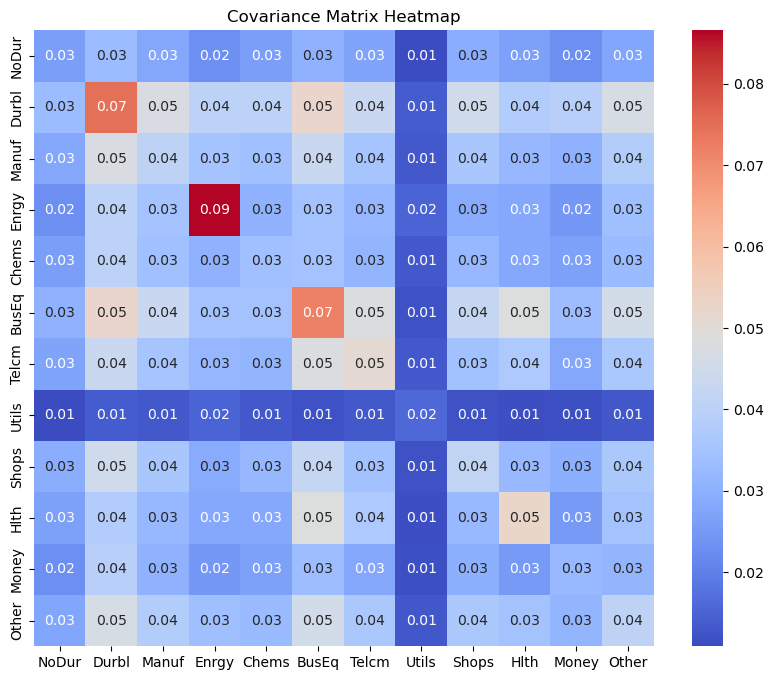

In [136]:
cov_ind=tmp[Industries].cov()*12

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_ind, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance Matrix Heatmap')
plt.show()



In [137]:
print(df7.columns.tolist())

['permno', 'date', 'Rn', 'shrout', 'siccd', 'prc', 'mcap', 'mcap_l', 'rf', 'Rm', 'Rn_e', 'Rm_e', 'const', 'beta', 'FF_12', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']


In [138]:
tmp = pd.merge(Strat,df7[['permno', 'date', 'Rn_e', 'beta', 'FF_12']],on=['date'], how='left')

# Industry Exposures as Dummy
tmp[Industries] = pd.get_dummies(tmp['FF_12']).replace({True: 1, False: 0})

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\904031874.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp[Industries] = pd.get_dummies(tmp['FF_12']).replace({True: 1, False: 0})


In [139]:
tmp.head()

,date,ret_rp,permno,Rn_e,beta,FF_12,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,1967-02-28,NaN,10006,-0.039840,1.426622,3.0,0,0,1,0,0,0,0,0,0,0,0,0
1,1967-02-28,NaN,10006,-0.039840,1.426622,3.0,0,0,1,0,0,0,0,0,0,0,0,0
2,1967-02-28,NaN,10014,-0.003737,1.801056,2.0,0,1,0,0,0,0,0,0,0,0,0,0
3,1967-02-28,NaN,10014,-0.003737,1.801056,2.0,0,1,0,0,0,0,0,0,0,0,0,0
4,1967-02-28,NaN,10057,-0.023567,1.551317,3.0,0,0,1,0,0,0,0,0,0,0,0,0


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\763383898.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta']+Industries]).fit().params)
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_40088\763383898.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['

              0         1
beta   0.832881  7.755049
NoDur  0.387828  2.468466
Durbl  0.173859  2.223758
Manuf  0.598677  3.070941
Enrgy  0.749452  4.764785
Chems  0.328179  2.026900
BusEq  0.485159  2.587404
Telcm  0.223145  1.632807
Utils  0.450127  2.967630
Shops  0.524598  2.929240
Hlth   0.245350  2.137629
Money  0.354864  2.989152
Other  0.300076  2.630623


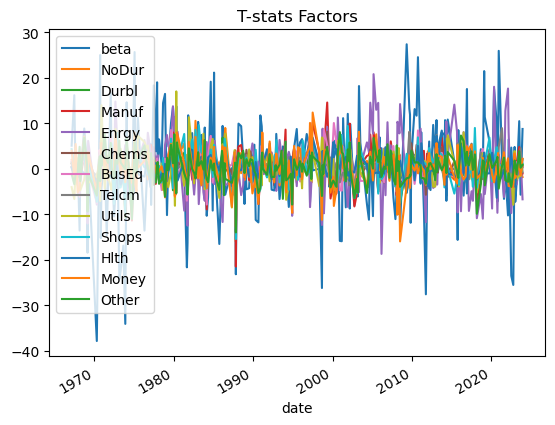

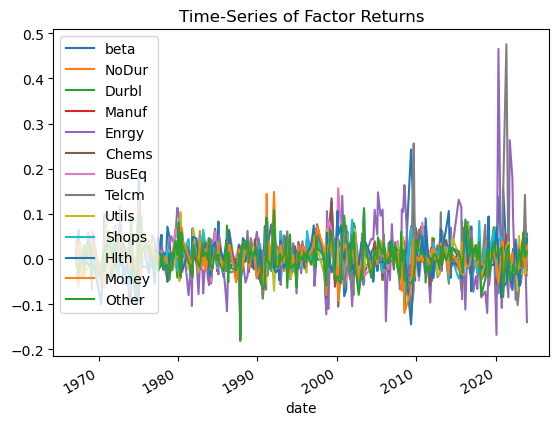

In [141]:
# Estimate Factor

Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta']+Industries]).fit().params)

Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'],x[['beta']+Industries]).fit().tvalues)

# Plot T-stats
Factors_tstats.plot(),plt.title('T-stats Factors')
Factors.plot(),plt.title('Time-Series of Factor Returns')
print(pd.concat([Factors_tstats.mean(),np.abs(Factors_tstats).mean()],axis=1))

### GPT analysis

#### Results:
- **Time-Varying Risk Premiums:**
  - Plots show that risk premiums for different industries and the market factor are not constant over time.
  - Significant periods of higher volatility, particularly around economic events (e.g., 2008 financial crisis, COVID-19 pandemic in 2020).

- **Significance of Factors:**
  - **Market Factor (`beta`):**
    - Average t-statistic: \(0.832881\)
    - Average absolute t-statistic: \(7.755049\)
    - Consistently significant impact on stock returns.
  - **Industry Factors:**
    - Notable industry factors with higher average t-statistics:
      - `Enrgy`: Average t-statistic: \(0.749452\), Average absolute t-statistic: \(4.764785\)
      - `Utils`: Average t-statistic: \(0.450127\), Average absolute t-statistic: \(2.967630\)
      - `Shops`: Average t-statistic: \(0.524598\), Average absolute t-statistic: \(2.929240\)
      - `Money`: Average t-statistic: \(0.354864\), Average absolute t-statistic: \(2.989152\)
      - `Manuf`: Average t-statistic: \(0.598677\), Average absolute t-statistic: \(3.070941\)
    - Industry factors show time-varying significance.

#### Key Observations:
- **Market Factor:**
  - Remains a critical determinant of stock returns, consistent with exercise results.
- **Industry Factors:**
  - Certain industry factors (e.g., `Enrgy`, `Utils`, `Shops`) demonstrate strong influence during specific periods.
- **Time Variation:**
  - Significance of industry factors fluctuates over time, indicating time-varying risk premiums.

#### Conclusion:
- **Dynamic Nature of Risk Premiums:**
  - Analysis confirms that risk premiums for market and industry factors are not static and fluctuate over time.
- **Importance of Time-Varying Models:**
  - Estimating constant coefficients may not adequately capture dynamic risk exposures. Time-varying models are recommended.
- **Factor Significance:**
  - High average absolute t-statistics for the market factor confirm its importance in explaining the cross-section of stock returns.
  - Industry factors also play a crucial role, but their impact varies over time.

### Most Relevant Industry Drivers of Strategy Risk

Based on the results you provided, the three industries that appear to be the most relevant drivers of the risk of the strategy can be identified by looking at the average t-statistics and their significance. The higher the absolute value of the t-statistic, the more significant the factor is in explaining the cross-section of stock returns.

#### Key Factors and Their Corresponding Average Absolute T-Statistics:

- **Enrgy (Energy)**
  - Average t-statistic: \(0.749452\)
  - Average absolute t-statistic: \(4.764785\)

- **Utils (Utilities)**
  - Average t-statistic: \(0.450127\)
  - Average absolute t-statistic: \(2.967630\)

- **Money (Finance)**
  - Average t-statistic: \(0.354864\)
  - Average absolute t-statistic: \(2.989152\)

#### Most Relevant Drivers:

1. **Energy (Enrgy)**
   - Energy has the highest average absolute t-statistic (\(4.764785\)), indicating that it is a significant driver of risk and returns in the strategy.

2. **Utilities (Utils)**
   - Utilities also have a high average absolute t-statistic (\(2.967630\)), suggesting it plays a significant role in the strategy's risk profile.

3. **Finance (Money)**
   - The Finance sector has a high average absolute t-statistic (\(2.989152\)), showing its importance in influencing the strategy's risk and returns.

#### Summary:

- **Energy, Utilities, and Finance** are the three most relevant industries driving the risk of your strategy.
- These sectors show consistent significance over time, as indicated by their high average absolute t-statistics.
- Considering the dynamic nature of these factors, monitoring their exposures will be crucial for risk management and strategy adjustment.
- These findings suggest that your strategy's performance is significantly influenced by these three industry factors, and changes in these sectors' economic conditions or market performance can materially impact your strategy's risk and returns.


In [142]:
Exposures = tmp[['date','ret_rp','beta'] + Industries].copy()
Exposures[Industries] = Exposures[Industries]*Exposures['ret_rp'].to_numpy()[:,np.newaxis]
Exposures['beta'] = Exposures['ret_rp'] * Exposures['beta']
Exposures = Exposures.groupby('date')[['beta'] + Industries].sum()

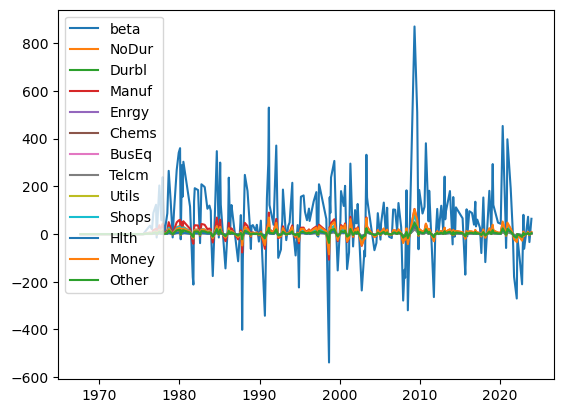

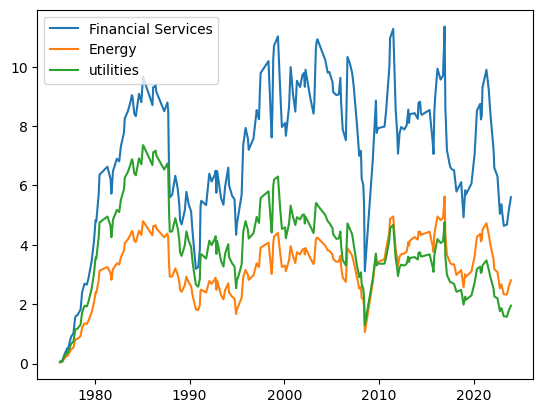

In [147]:
# Plot Exposure to all industries
plt.plot(Exposures)
plt.legend(Exposures.columns)
plt.show()


# Plot Exposure to Tech and Finance
plt.plot(Exposures['Money'].rolling(36).mean())
plt.plot(Exposures['Enrgy'].rolling(36).mean())
plt.plot(Exposures['Utils'].rolling(36).mean())
plt.legend(['Financial Services','Energy','utilities'])
plt.show()

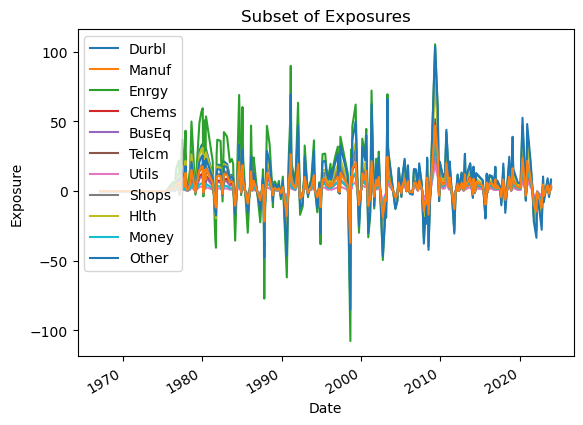

In [150]:
subset_exposures = Exposures.drop(columns=['beta'])
subset_exposures.plot()
plt.xlabel('Date')
plt.ylabel('Exposure')
plt.title('Subset of Exposures')
plt.legend(subset_exposures.columns[1:])
plt.show()

## c)

In [152]:
# Hedge Portfolio Return
Hedge_Return = Factors * Exposures.rename(columns={'beta':'Rm_e'})
Hedge_Return = Hedge_Return.sum(axis=1)

strat_hedge = Strat.set_index('date')-Hedge_Return.to_numpy()[:,np.newaxis]
print('strategy-Hedged Return: ', strat_hedge.mean()*12)
print('strategy-Hedged Std: ', strat_hedge.std()*np.sqrt(12))
print('strategy-Hedged Sharpe: ', strat_hedge.mean()/strat_hedge.std()*np.sqrt(12))

strategy-Hedged Return:  ret_rp   -24.426757
dtype: float64
strategy-Hedged Std:  ret_rp    20.63434
dtype: float64
strategy-Hedged Sharpe:  ret_rp   -1.183791
dtype: float64


# PART 8

In [ ]:
df7['FF_12'].get_